Data:
- scaled to range [0:1] features: sent_ken, TOKEN, 
- no feature 'idx'
- binary features replaces from 0/1 to 0/.067 according to mean value of rest of the features
- test ratio  is 10%
- NO stop words for tfid
- XXX XXXX replaced with XXX
- removed XXXword sticky occurances 
- short sentences merged into long (3+ words)

In [3]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.pipeline import Pipeline


In [4]:
dir_name="scaled_minmax"

In [5]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/scaled_minmax'

In [7]:
dir_name

'scaled_minmax'

## Prepare TfIdf without stop words

In [6]:
tf_char = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=False,per_lemma=False,analyzer="char_wb")
tf_lemma = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=True,per_lemma=True,analyzer="word")
tf_word = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=True,per_lemma=False,analyzer="word")

TfIdf char_wb vocab size 31371
Sample of 31371 features
[' 1 ', ' 10', ' 10 ', ' 100', ' 100 ', ' 11', ' 11 ', ' 12', ' 12 ', ' 13', ' 14', ' 14 ', ' 15', ' 15 ', ' 150', ' 150 ', ' 16', ' 16 ', ' 17', ' 17 ']
['ועבר', 'ועבר ', 'ועברת', 'ועד', 'ועד ', 'ועדו', 'ועדון', 'ועדונ', 'ועדי', 'ועדיי', 'ועדת', 'ועדת ', 'ועה', 'ועה ', 'ועו', 'ועוב', 'ועוד', 'ועוד ', 'ועוש', 'ועושה']
[' 1 ', ' ועשי', ' סמים', 'באול', 'החלק', 'ועדיי', 'ינתך ', 'מבקש', 'סירו', 'ריירה', '״ר ']
0 1 2 

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TfIdf lemma vocab size 9119
Sample of 9119 features
['CBT', 'CBTיסטי', 'DO', 'HAVE', 'HIV', 'Inciden', 'LIST', 'Lierally', 'NICE', 'NLP', 'OCD', 'OFF', 'ON', 'SAY', 'SMS', 'TO', 'TRX', 'Therapy', 'Too', 'XX']
['לוט', 'לוי', 'לום', 'לומד', 'לונדון', 'לונדיני', 'לונדיניות', 'לונדינית', 'לוף', 'לופ', 'לוציונציות', 'לוצינציות', 'לוקסוס', 'לוקש', 'לושיהיה', 'לזה', 'לזוגיותאם', 'לזכות', 'לח', 'לחברון']
['CBT', 'אתשגרה', 'הבעיר', 'התבונן', 'חרדי', 'לוציונציות', 'מעוצב', 'סופר', 'פרגמטיקה', 'שדרה']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TfIdf word vocab size 24619
Sample of 24619 featur

In [8]:
tf_features = {}
tf_features['word'] = tf_word.get_feature_names_out()
tf_features['lemma'] = tf_lemma.get_feature_names_out()
tf_features['char_wb'] = tf_char.get_feature_names_out()

In [9]:
imp.reload(common_utils)
tf_f_list  =common_utils.convert_to_list(tf_features)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"tf.no_stop_features_map.json")
with open(json_path, 'w') as fp:
    json.dump(tf_f_list, fp,ensure_ascii=False)

In [11]:
scaled_name='scaled.binary0.067_merged'

In [14]:
imp.reload(feature_utils)
scaled_docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','char_wb','lemma'],
                                                              merged_str = scaled_name
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14918 items packed for 80 docs


In [15]:
imp.reload(common_utils)
common_utils.get_random_sample(scaled_docs_map)

[{'is_question': 0,
  'sent_len': 0.007826610475617,
  'is_client': 1,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.5822784810126582,
  'TOKEN': 0.0099009900990099,
  'POSTAG_JJ': 0.5,
  'POSTAG_NN': 0.5,
  'POSTAG_PREPOSITION': 0.5,
  'f_gen_F': 1.0,
  'f_num_S': 1.0,
  '-1:is_question': 0,
  '-1:sent_len': 0.0108368452739313,
  '-1:is_client': 0,
  '-1:sent_pos_in_par': 1.0,
  '-1:sent_pos_in_doc': 0.579746835443038,
  '-1:TOKEN': 0.0247524752475247,
  '-1:POSTAG_DEF': 0.2,
  '-1:POSTAG_NN': 0.2,
  '-1:POSTAG_PRP': 0.4,
  '-1:POSTAG_QW': 0.2,
  '-1:POSTAG_RB': 0.2,
  '-1:f_gen_F': 0.2,
  '-1:f_gen_M': 0.4,
  '-1:f_num_S': 0.6,
  '-1:f_per_3': 0.4,
  '+1:is_question': 0,
  '+1:sent_len': 0.024683925346177,
  '+1:is_client': 0,
  '+1:sent_pos_in_par': 1.0,
  '+1:sent_pos_in_doc': 0.5848101265822785,
  '+1:TOKEN': 0.0396039603960396,
  '+1:POSTAG_COP': 0.125,
  '+1:POSTAG_DEF': 0.25,
  '+1:POSTAG_INTJ': 0.125,
  '+1:POSTAG_JJ': 0.125,
  '+1:POSTAG_NN': 0.25,
  '+1:POSTAG_NNT': 0.125

In [16]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"min.max.sacled_no.stop_docs_map.json")

with open(json_path, 'w') as fp:
    json.dump(scaled_docs_map, fp)


In [17]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(scaled_docs_map,per_par,seq_len,step)

[58] 384 -> 128 [67] 407 -> 136 [72] 420 -> 140 [53] 149 -> 50 [46] 200 -> 67 [79] 172 -> 58 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [9] 276 -> 92 [23] 74 -> 25 [36] 87 -> 29 [17] 322 -> 108 [2] 156 -> 52 [80] 223 -> 75 [28] 167 -> 56 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [78] 122 -> 41 [52] 275 -> 92 [47] 160 -> 54 [66] 366 -> 122 [73] 85 -> 29 [59] 370 -> 124 [24] 158 -> 53 [31] 79 -> 27 [10] 123 -> 41 [5] 65 -> 22 [29] 105 -> 35 [16] 102 -> 34 [3] 113 -> 38 [22] 89 -> 30 [37] 99 -> 33 [8] 82 -> 28 [60] 245 -> 82 [75] 68 -> 23 [54] 243 -> 81 [41] 137 -> 46 [32] 73 -> 25 [27] 67 -> 23 [18] 62 -> 21 [39] 111 -> 37 [6] 420 -> 140 [13] 90 -> 30 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [76] 132 -> 44 [63] 338 -> 113 [49] 206 -> 69 [68] 439 -> 147 [42] 136 -> 46 [57] 271 -> 91 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [7] 248 -> 83 [12] 150 -> 50 [38] 90 -> 30 [19] 265 -> 89 [33] 91 -> 31 [26] 114 -> 38 [71] 156 -> 52 [64] 347 -

In [18]:
X=np.arange(0,81)
X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [19]:
test_percent=0.2
n_groups=int(test_percent*len(scaled_docs_map.keys()))

In [20]:
imp.reload(model_utils)
myGrFold=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=3)

In [21]:
for tr,ts in myGrFold.split(X=X,groups=X):
    print(tr,ts)

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[15 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16]
[15 16 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]


In [22]:
imp.reload(model_utils)
test_percent = 0.1
seed=42
n_test_groups=int(len(scaled_docs_map.keys())*test_percent)
cross_test_cv=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=1)
all_groups=list(scaled_docs_map.keys())
for train_indices,test_indices in cross_test_cv.split(X=all_groups,groups=all_groups):
    print(train_indices,test_indices)

[ 0  1  2  3  4  5  8  9 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 31 34 35 37 38 39 40 41 42 43 44 47 48 49 50 51 52 53 54 55 56 58 59
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77] [ 6  7 10 14 29 30 32 33 36 45 46 57 60 61 78 79]


In [23]:
train_indices=np.array(train_indices)+1
test_indices=np.array(test_indices)+1

In [24]:
print(train_indices,test_indices)

[ 1  2  3  4  5  6  9 10 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 32 35 36 38 39 40 41 42 43 44 45 48 49 50 51 52 53 54 55 56 57 59 60
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78] [ 7  8 11 15 30 31 33 34 37 46 47 58 61 62 79 80]


In [25]:
imp.reload(model_utils)
X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(scaled_docs_map,train_indices,seq_len,step)

In [26]:
len(groups_train),len(y_train)

(4060, 4060)

In [27]:
X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(scaled_docs_map,test_indices,seq_len,step)
len(groups_test),len(y_test)

(939, 939)

In [28]:
%%time
# define fixed parameters and parameters to search
n_groups=int(test_percent*len(train_indices))
my_cv=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=3)
crf_scaled = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled = RandomizedSearchCV(crf_scaled, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs_scaled.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 22s, sys: 55.7 s, total: 5min 18s
Wall time: 5min 30s


RandomizedSearchCV(cv=MyLeavePGroupsOut(n_groups=6, n_splits=3),
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8a7da6b6a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8a7da6b970>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [29]:
# crf = rs.best_estimator_
print('best params:', rs_scaled.best_params_)
print('best CV score:', rs_scaled.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.9354875649501326, 'c2': 0.005104451277376284, 'min_freq': 5}
best CV score: 0.8003755621655944
model size: 0.20M


In [30]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_min.max.scaled.json")

best_params_pyth = common_utils.convert_to_python_types(rs_scaled.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)



              precision    recall  f1-score   support

      is_nar       0.63      0.59      0.61      1604
     not_nar       0.86      0.88      0.87      4791

    accuracy                           0.81      6395
   macro avg       0.75      0.74      0.74      6395
weighted avg       0.81      0.81      0.81      6395



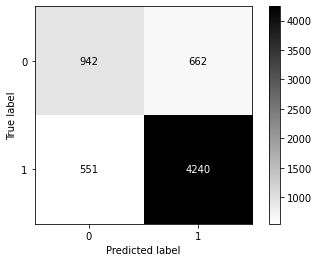

In [31]:
best_crf = rs_scaled.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf_scaled.classes_)

### Look at the features


In [32]:
dir_name

'scaled_minmax'

In [35]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf.state_features_).most_common(),"tf.no_stop_features_map.json")

In [36]:
all_features_cv.iloc[:30]

,weight,label,attr,string
0,3.522085,not_nar,tfidf_word_21019,שאמרת
1,3.332444,not_nar,-1:f_suf_per_2.0,
2,3.094725,is_nar,tfidf_lemma_463,איכל
3,3.027738,is_nar,tfidf_word_22547,שלח
4,2.881314,is_nar,tfidf_lemma_8414,שיר
5,2.850200,is_nar,tfidf_word_24461,תקשיבי
6,2.841375,is_nar,tfidf_word_2639,בנות
7,2.758701,is_nar,tfidf_lemma_847,ארגן
8,2.663223,is_nar,tfidf_lemma_1410,גוגל
9,2.615702,not_nar,tfidf_lemma_1062,בחיר


In [37]:
all_features_cv[all_features_cv['label']=='is_nar'][:30]

,weight,label,attr,string
2,3.094725,is_nar,tfidf_lemma_463,איכל
3,3.027738,is_nar,tfidf_word_22547,שלח
4,2.881314,is_nar,tfidf_lemma_8414,שיר
5,2.850200,is_nar,tfidf_word_24461,תקשיבי
6,2.841375,is_nar,tfidf_word_2639,בנות
7,2.758701,is_nar,tfidf_lemma_847,ארגן
8,2.663223,is_nar,tfidf_lemma_1410,גוגל
16,2.116470,is_nar,tfidf_word_901,אמרה
18,2.043365,is_nar,tfidf_lemma_7693,קיבע
21,1.966109,is_nar,tfidf_lemma_6008,ניהול


In [38]:
all_features_cv[all_features_cv['attr'].str.contains("POS")][:30]

,weight,label,attr,string
265,0.312383,is_nar,-1:POSTAG_INTJ,
348,0.220804,not_nar,+1:POSTAG_COP,
355,0.216912,not_nar,-2:POSTAG_CDT,
414,0.158902,not_nar,-2:POSTAG_EX,
432,0.147279,not_nar,+1:POSTAG_EX,
441,0.143709,not_nar,+1:POSTAG_CDT,
478,0.127172,is_nar,+1:POSTAG_ADVERB,
481,0.126346,not_nar,+2:POSTAG_EX,
489,0.122545,is_nar,-2:POSTAG_NNP,
510,0.113074,not_nar,-2:POSTAG_MD,


### Save all features db

In [39]:
f_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"crf_features.csv")
all_features_cv.to_csv(f_path,index=False)

## Feature selection based on weight

<AxesSubplot:ylabel='Frequency'>

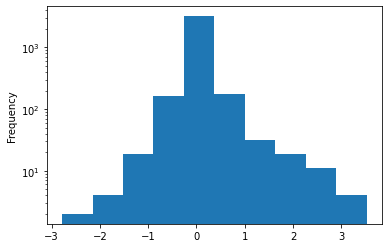

In [40]:
all_features_cv['weight'].plot(kind='hist',logy=True)

In [42]:
q = all_features_cv['weight'].quantile(q=[0.1, 0.9])
q

0.100000   -0.108292
0.900000    0.206158
Name: weight, dtype: float64

In [43]:
q.iloc[0],q.iloc[1]

(-0.10829239999999998, 0.20615790000000067)